In [1]:
# 1. 加载文档
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://zh.wikipedia.org/wiki/黑神话：悟空",)
)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# 2. 文档分块
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [3]:
# 3. 设置嵌入模型
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-zh-v1.5",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

c:\Users\huangj2\Documents\Venv\langchain_250321\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 4. 创建向量存储
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(all_splits)

['604669d1-40eb-4a62-9584-e973179bffdd',
 '5ef199b6-3764-48a9-aaa9-8631c332dd79',
 '105c0f5c-48fd-4f08-a4fb-7798dbbad476',
 'ceb97d36-c737-4311-bd0b-73e1551f2023',
 '639620ef-eb56-4ff2-a1ba-c6b94da1dafe',
 '331148e2-5f88-4938-866a-1b25c71a3331',
 'a56dbfef-983a-4067-9d35-96f936676c9f',
 'e77501a8-f91b-4a5a-a461-be92666fa9b8',
 'b0771461-eddc-4a96-a338-2dcc6cf61e6c',
 '05e64899-c094-4de6-9e45-9f607a198aea',
 '35c28dbc-04d3-4708-8283-91f00416709c',
 'bf110bbf-8350-44e1-abcc-0949cef94ab2',
 '77b227ab-580b-4921-ad21-10650f6fed41',
 '5feea8e3-baf4-4f1a-ab58-9067c0747106',
 '9fec31c1-b267-4f9d-8f44-8c803e14f325',
 'f45ce91f-9bd5-4c0c-9eed-c90ed79e4e0e',
 '306eda04-b798-41a3-aa54-a53be73e53a5',
 '49bd7b4e-c51f-4fcb-b370-3297b4dd5b20',
 'd88fc80b-f89c-4277-8b7f-b8a2b5430986',
 '16fc58cd-75ed-4529-b7ae-a7bb08825159',
 '44a1f23e-8fa1-435d-9031-40038362ee9d',
 'f507dc8f-bf14-4fc7-abc3-71531eec82cc',
 '7203a50e-6efd-41cb-a6b0-ed23fd11cf37',
 '8a43eb83-6501-4c8d-9c77-95e72858206a',
 '33ceeb43-e1dd-

In [5]:
# 5. 定义RAG提示词
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

c:\Users\huangj2\Documents\Venv\langchain_250321\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
# 6. 定义应用状态
from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [7]:
# 7. 定义检索步骤
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [8]:
# 8. 定义生成步骤
def generate(state: State):
    from langchain_openai import ChatOpenAI
    llm = ChatOpenAI(model="gpt-4")
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

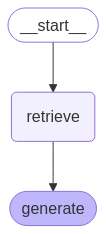

In [9]:
# 9. 构建和编译应用
from langgraph.graph import START, StateGraph
graph = (
    StateGraph(State)
    .add_sequence([retrieve, generate])
    .add_edge(START, "retrieve")
    .compile()
)

# 显示图结构
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:
# 10. 运行查询
question = "黑悟空有哪些游戏场景？"
response = graph.invoke({"question": question})
print(f"\n问题: {question}")
print(f"答案: {response['answer']}")


问题: 黑悟空有哪些游戏场景？
答案: 《黑神话：悟空》的游戏场景中融合了很多中国的文化和自然地标，比如重慶的大足石刻、山西省的小西天、南禅寺、铁佛寺、广胜寺和鹳雀楼等。游戏的故事发生在《西游记》之后，玩家在游戏中需要探索并通过一系列的冒险任务，寻找遗失根器并尝试复活孙悟空。游戏的篇章设定为六个章节，分别为“火照黑云”、“风起黄昏”、“夜生白露”、“曲度紫鸳”、“日落红尘”和“未竟”。
